In [1]:
import tensorflow as tf
import sys
sys.path.insert(0, '/home/karthik/code/pytools/src/')
from tftools import network as net

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from tftools import data

In [3]:
class EndPositionImaginer(net.Network):
    def __init__(self, img, name, reuse=False):
        self.image = tf.pad(img, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        self.name = name 
        self.layers = {'image':self.image}
        self.trainable = True
        self.initializer = tf.truncated_normal_initializer(stddev=0.02)
        self.reuse = reuse
        self.vars = []
        self.setup()
        
    @net.layer
    def padder(self, x, p, name=None):
        return tf.pad(x,  [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT", name=self.name)
    

    def residule_block(self, x, k, c_o, s, name):
        p = int((k - 1) / 2)
        (self.feed(x)
        .padder(p, name=name+'p_1')
        .conv2d_slim(c_o, k, s, name=name+'_c1',relu=False, padding='VALID', reuse=self.reuse, biased=False)
        .instance_norm(name=name+'_bn1', reuse=self.reuse, relu=False)
        .padder(p, name='p_2')
        .conv2d_slim(c_o, k, s, name=name+'_c2',relu=False, padding='VALID', reuse=self.reuse, biased=False)
        .instance_norm(name=name+'_bn2', reuse=self.reuse, relu=False))
        (self.feed(x, name+'_bn2')
        .add(name=name))
                            
    def setup(self):
        with tf.variable_scope(self.name):
            (self.feed("image")
             .conv2d_slim( 32, 7, 1, name='g_e1_c', relu=False, padding='VALID', reuse=self.reuse, biased=False)
             .instance_norm(name="g_e1_bn", reuse=self.reuse, relu=True)
             .conv2d_slim( 64, 3, 2, name='g_e2_c', relu=False, reuse=self.reuse, biased=False)
             .instance_norm(name="g_e2_bn", reuse=self.reuse, relu=True)
             .conv2d_slim( 128, 3, 2, name='g_e3_c', relu=False, reuse=self.reuse, biased=False)
             .instance_norm(name= "g_e3_bn", reuse=self.reuse, relu=True))
            self.residule_block('g_e3_bn', 3, 128, 1, name='g_r1')
            self.residule_block('g_r1', 3, 128, 1, name='g_r2')
            self.residule_block('g_r2', 3, 128, 1, name='g_r3')
            self.residule_block('g_r3', 3, 128, 1, name='g_r4')
            self.residule_block('g_r4', 3, 128, 1, name='g_r5')
            self.residule_block('g_r5', 3, 128, 1, name='g_r6')
            self.residule_block('g_r6', 3, 128, 1, name='g_r7')
            self.residule_block('g_r7', 3, 128, 1, name='g_r8')
            self.residule_block('g_r8', 3, 128, 1, name='g_r9')
            (self.feed('g_r9')
             .deconv(64,  name='g_d1_dc', ks=3, s=2, reuse=self.reuse)
             .instance_norm(name="g_d1_bn", reuse=self.reuse, relu=True)
             .deconv(32, name='g_d2_dc', ks=3, s=2, reuse=self.reuse)         
             .instance_norm(name="g_d2_bn", reuse=self.reuse, relu=True)
             .padder(3, name='pad2')
             .conv2d_slim(3, 7, 1, name='g_pred_c', reuse=self.reuse, padding='VALID')
             .instance_norm(name="g_pred_bn", reuse=self.reuse)
             .tanh(name='pred')
            )
    def pred(self):
        return self.layers['pred']
    
    def get_vars(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
        
        
        

In [4]:
from glob import glob
import numpy as np
dataA = glob('/data/image/imagenet/artefact/*.JPEG')
np.random.shuffle(dataA)


In [5]:
def mean_sq_error(in_, target):
    return tf.reduce_mean((in_-target)**2)

def abs_error(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))


img_pl = tf.placeholder(tf.float32, [None, 224, 224, 3], name='Image')


In [6]:
net = EndPositionImaginer (img_pl, 'A3')

In [7]:
net.pred()

<tf.Tensor 'A3/pred:0' shape=(?, 224, 224, 3) dtype=float32>

##  Train on imagenet

In [ ]:
LAMBDA = 10.
enc_loss = abs_error(net.pred() ,img_pl)

loss_sum = tf.summary.scalar('enc_loss', enc_loss),
img_sum = tf.summary.image("out", net.pred())
net_sum = tf.summary.merge([loss_sum, img_sum,  tf.summary.image("IMG",img_pl)])

optim = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(enc_loss, var_list=net.get_vars())


In [ ]:
from glob import glob
import numpy as np
# dataA = glob('/data/deep/cyclegan/horse2zebra/trainA/*')
dataA = glob('/data/image/imagenet/artefact/*.JPEG')
np.random.shuffle(dataA)

In [ ]:
batch_idxs = min(len(dataA), 1e8) // 1
EPOCHS = 80
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [ ]:
writer = tf.summary.FileWriter("/tmp/logs", sess.graph)

In [ ]:
from imgtools import utils as imgutils

from tqdm import tnrange

In [ ]:
import scipy
def load(im_loc, load_size=256, fine_size=224):
    im = scipy.misc.imread(im_loc, mode='RGB').astype(np.float)
    img = scipy.misc.imresize(im, [load_size, load_size])
    h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    img = img[h1:h1+fine_size, w1:w1+fine_size]
    if np.random.random() > 0.5:
        img = np.fliplr(img)
    img = img/127.5 - 1.
    return img

In [ ]:
from tqdm import tnrange
import collections
last_100 = collections.deque(100*[100], 100) 

In [ ]:
epoch_range = tnrange(0,EPOCHS, desc='Epochs:')
for epoch in epoch_range:
    batch_range = tnrange(batch_idxs, desc='Epoch %d, Batch Index: '%epoch)
    np.random.shuffle(dataA)
    for idx in batch_range:        
        imgA = load(dataA[idx], load_size=256, fine_size=224)
        feed_dict={img_pl:imgA.reshape((1,224,224,3))}

        _, lv = sess.run([optim, enc_loss], feed_dict=feed_dict)
        last_100.append(lv)
        if idx%100 == 0 and idx>0:
            summary_str = sess.run(net_sum, feed_dict=feed_dict)
            writer.add_summary(summary_str, batch_idxs*epoch + idx)   
        batch_range.set_postfix(loss=np.mean(last_100))
    epoch_range.set_postfix(loss=np.mean(last_100))
        

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(sess, '/data/robotics/stepped/models/model_base')

## Extract training data from episodes

In [74]:
def load_current_and_target_images(train_fl):
    steps_cnt = data.TFDataReader(train_fl).count()
    train_inp = np.zeros([2, steps_cnt, 224, 224, 3], dtype=np.uint8)
    train_labels = np.zeros([steps_cnt, ], dtype=np.int32)
    train_states = np.zeros([steps_cnt, 6], dtype=np.float32)
    idx = 0
    reader = data.TFDataReader(train_fl)
    fds = reader.readall((["left_image", data.IMG_TYP],
                              ["right_image", data.IMG_TYP],
                              ['motor', data.INT_TYP],
                              ['direction', data.INT_TYP],
                              ['motor_state', data.FLT_TYP]))
    for fd in fds:
        train_inp[0, idx, ...] = resize_to_model(fd['left_image'])
        train_inp[1, idx, ...] = resize_to_model(fd['right_image'])
        motor = int(fd['motor'][0])
        direction = int(fd['direction'][0])
#         train_states[idx, :] = np.array(fd['motor_state'])
        label = motor_2_label(motor, direction)
        train_labels[idx] = label
        idx += 1
  
    t1 = train_inp[:,-1,...]
    ends = np.tile(t1,[steps_cnt,1,1,1,1])
    final_images = ends.transpose([1,0,2,3,4])
    return ((train_inp, train_labels, train_states, final_images), steps_cnt)

    

In [9]:
import cv2
def resize_to_model(im, shape=(224, 224)):
    return cv2.resize(im, shape)


def motor_2_label(motor, direction):
    return 2*motor+(direction+1)/2

def from_buffer(im_str, sz, dtype_dat):
    f1 = np.fromstring(im_str, dtype=dtype_dat)
    return f1.reshape(sz)

In [10]:
train_data_base =  '/data/robotics/stepped/data/'
import os
base_images = []
target_images = []
for fl in os.listdir(train_data_base):
    if fl.endswith('.tfrecords'):
        try:
            ((train_inp, train_labels, train_states, final_images), steps_cnt) = load_current_and_target_images(
                os.path.join(train_data_base,fl))
            for i in range(steps_cnt):
                for j in range(2):
                    base_images.append(train_inp[j,i,...])
                    target_images.append(final_images[j,i,...])
        except:
            continue
        

In [11]:
def load(im_loc, load_size=256, fine_size=224):
    im = scipy.misc.imread(im_loc, mode='RGB').astype(np.float)
    img = scipy.misc.imresize(im, [load_size, load_size])
    h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    img = img[h1:h1+fine_size, w1:w1+fine_size]
    if np.random.random() > 0.5:
        img = np.fliplr(img)
    img = img/127.5 - 1.
    return img

def normalize(im):
    im = im/127.5 - 1
    return im

def preprocess_images((base_img, target_img)):
    result = [(normalize(base_img), normalize(target_img))] 
    base_img = np.fliplr(base_img)
    target_img = np.fliplr(target_img)
    return [(normalize(base_img), normalize(target_img))] + result
    
dataBT = []
for x in zip(base_images, target_images):
    dataBT+=preprocess_images(x)
    

In [12]:
batch_idxs = len(dataBT)

In [13]:
target_img_pl = tf.placeholder(tf.float32, [None, 224, 224, 3], name='Image')

In [14]:
enc_loss = abs_error(net.pred() ,target_img_pl)

loss_sum = tf.summary.scalar('enc_loss', enc_loss),
img_sum = tf.summary.image("out", net.pred())
net_sum = tf.summary.merge([loss_sum, img_sum,  tf.summary.image("IMG",img_pl)])

optim = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(enc_loss, var_list=net.get_vars())


In [15]:
EPOCHS = 80
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [16]:
saver = tf.train.Saver()

In [17]:
saver.restore(sess, '/data/robotics/stepped/models/model_base')

In [18]:
writer = tf.summary.FileWriter("/tmp/logs_base_target_train", sess.graph)

In [19]:
from tqdm import tnrange
import collections
last_100 = collections.deque(100*[100], 100) 

In [21]:
epoch_range = tnrange(0,EPOCHS, desc='Epochs:')
for epoch in epoch_range:
    batch_range = tnrange(len(dataBT), desc='Epoch %d, Batch Index: '%epoch)
    np.random.shuffle(dataBT)
    for idx in batch_range:
        imgA, targetA = dataBT[idx]
        feed_dict={img_pl:imgA.reshape((1,224,224,3)), target_img_pl:targetA.reshape((1,224,224,3))}

        _, lv = sess.run([optim, enc_loss], feed_dict=feed_dict)
        last_100.append(lv)
        if idx%100 == 0 and idx>0:
            summary_str = sess.run(net_sum, feed_dict=feed_dict)
            writer.add_summary(summary_str, batch_idxs*epoch + idx)   
        batch_range.set_postfix(loss=np.mean(last_100))
    epoch_range.set_postfix(loss=np.mean(last_100))


In [24]:
%matplotlib inline

In [22]:
saver.save(sess, '/data/robotics/stepped/models/model_imagine_end')

'/data/robotics/stepped/models/model_imagine_end'

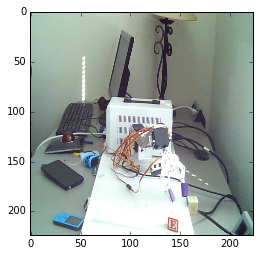

In [52]:
plt.imshow((normalize(target_images[0])+1)/2.)

In [41]:
np.min(normalize(target_images[0]))

-1.0

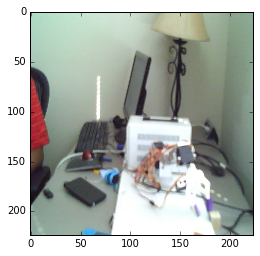

In [49]:
plt.imshow(target_images[7])

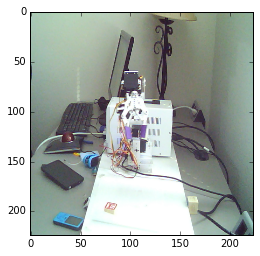

In [68]:
plt.imshow(base_images[200])

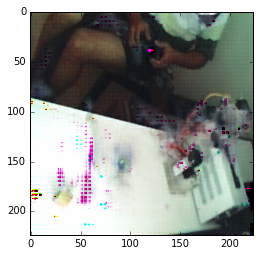

In [82]:
out = sess.run([net.pred()],
               {img_pl: normalize(train_inp[1,0,...]).reshape((1,224,224,3))})

plt.imshow((out[0][0]+1.)/2)

In [75]:
((train_inp, train_labels, train_states, final_images), steps_cnt) = load_current_and_target_images(
                '/data/robotics/pick_episodes_2/episode_1.tfrecords')

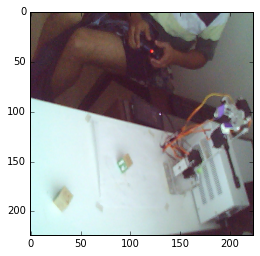

In [81]:
plt.imshow(train_inp[1,0,...])